# Last-layer methods
(It's all classifical Bayesian stuff)

In [1]:
import jax
import jax.numpy as jnp
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
%config InlineBackend.figure_format = "retina"
plt.rcParams["axes.spines.right"] = False
plt.rcParams["axes.spines.top"] = False
plt.rcParams["font.size"] = 12
plt.rcParams["figure.figsize"] = (7.2, 4.0)

sns.set_palette("colorblind")

# Bayesian linear regression
And the in-between uncertainty

In [622]:
def phi(x):
    return x ** 3

In [623]:
key = jax.random.PRNGKey(3141)
key_data, key_samples = jax.random.split(key)

sigma = 0.3
c = 0.01

In [624]:
n_obs_all = 100
key_x, key_y = jax.random.split(key_data)
x_all = jax.random.uniform(key_x, (n_obs_all,), minval=-7.5, maxval=7.5)
y_all = c * phi(x_all) + jax.random.normal(key_y, shape=(n_obs_all,)) * sigma

mask_vals = jnp.logical_and(jnp.abs(x_all) > 2, jnp.abs(x_all) < 5)
x, y = x_all[mask_vals, None], y_all[mask_vals, None]
n_obs = len(x)

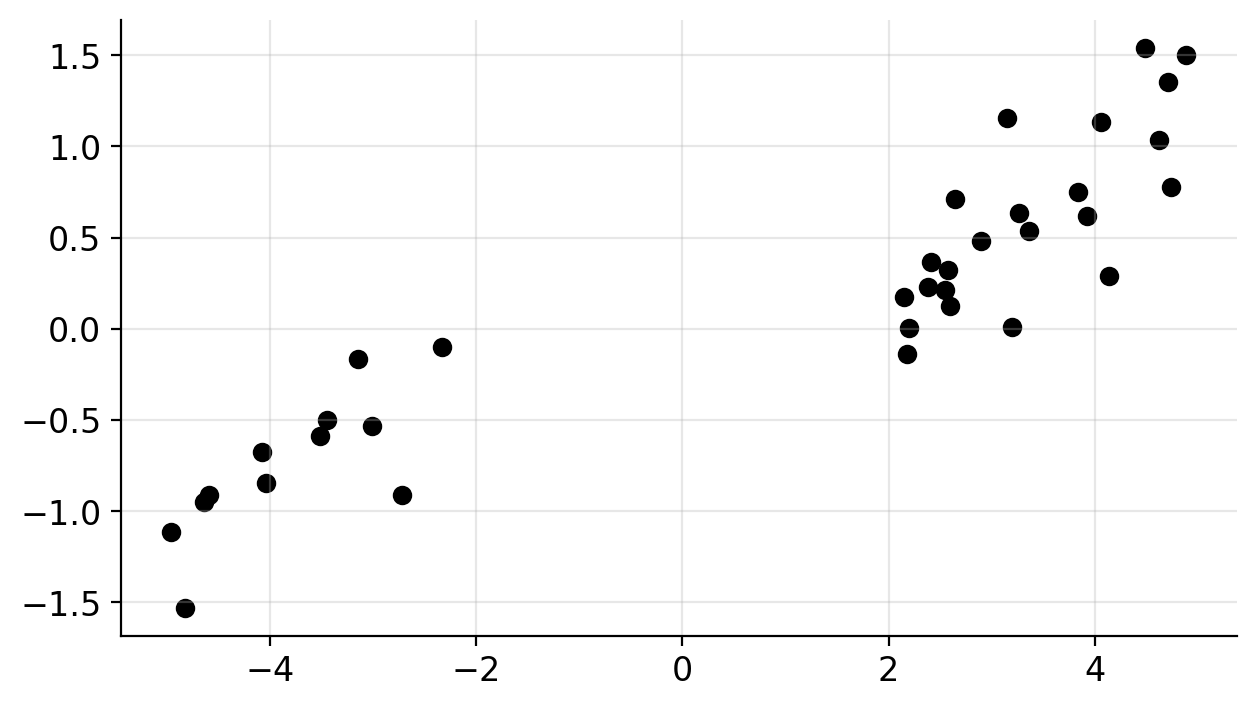

In [625]:
plt.scatter(x, y, c="black")
plt.grid(alpha=0.3)

## Bayesian linear regresion (with known variance)

Suppose
$$
    p(y | x, \beta) = {\cal N}(y | \theta^\intercal\,\phi(x), \beta^{-1})
$$

In [626]:
def phi(x):
    return x ** 3

In [627]:
M = x.shape[1]
IM = jnp.eye(M)
beta = 1 / sigma ** 2 # precision observation

In [628]:
alpha = 1.0
posterior_precision = alpha * IM + beta * phi(x).T @ phi(x)
posterior_mean = beta * jnp.linalg.solve(posterior_precision, phi(x).T @ y)
posterior_mean = posterior_mean.ravel()

In [629]:
n_test_eval = 1000
xeval = jnp.linspace(-6, 6, n_test_eval)
phi_eval = phi(xeval)[:, None]

In [630]:
pred_var = 1 / beta + jnp.einsum("si,ij,sj->s", phi_eval, jnp.linalg.inv(posterior_precision), phi_eval)
pred_std = jnp.sqrt(pred_var)

pred_mean = jnp.einsum("d,td->t", posterior_mean, phi_eval)

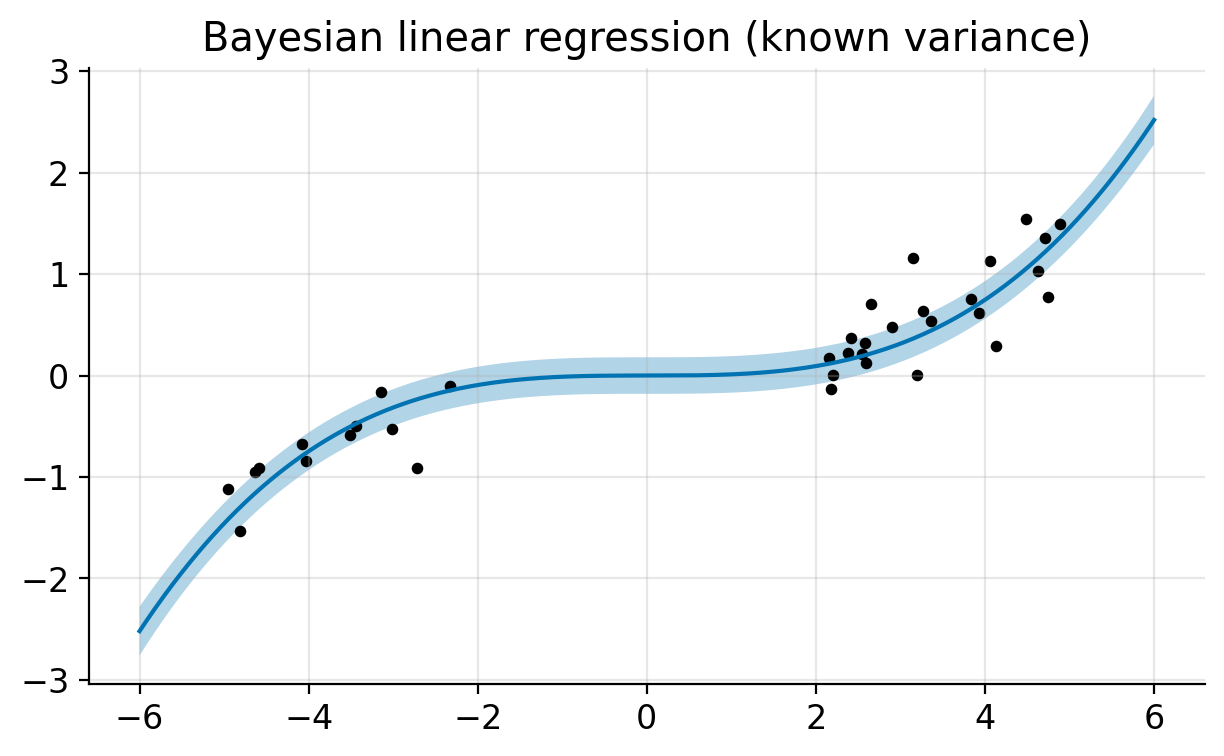

In [631]:
pred_ubound = pred_mean + 2 * pred_var
pred_lbound = pred_mean - 2 * pred_var
plt.fill_between(xeval, pred_lbound, pred_ubound, alpha=0.3)
plt.plot(xeval, pred_mean)
plt.scatter(x, y, c="black", s=10)
plt.title("Bayesian linear regression (known variance)")
plt.grid(alpha=0.3)

## Neural Bayesian last layer

In [632]:
import flax.linen as nn
import optax
from flax.training.train_state import TrainState

In [633]:
class MLP(nn.Module):
    @nn.compact
    def __call__(self, x):
        x = nn.Dense(10)(x)
        x = jnp.sin(x)
        x = nn.Dense(10)(x)
        x = jnp.sin(x)
        x = nn.Dense(1, name="last-layer")(x)
        return x

In [662]:
model = MLP()
key = jax.random.PRNGKey(314)
params_init = model.init(key, x)

In [663]:
def lossfn(params):
    yhat = model.apply(params, x).squeeze()
    return jnp.power(y.squeeze() - yhat, 2).mean()

In [666]:
def step(state, _):
    loss, grads = jax.value_and_grad(lossfn)(state.params)
    state = state.apply_gradients(grads=grads)
    return  state, loss

n_steps = 3_000
state = TrainState.create(params=params_init, apply_fn=model.apply, tx=optax.adam(1e-3))
state_final, loss = jax.lax.scan(step, state, jnp.arange(n_steps))
params = state_final.params

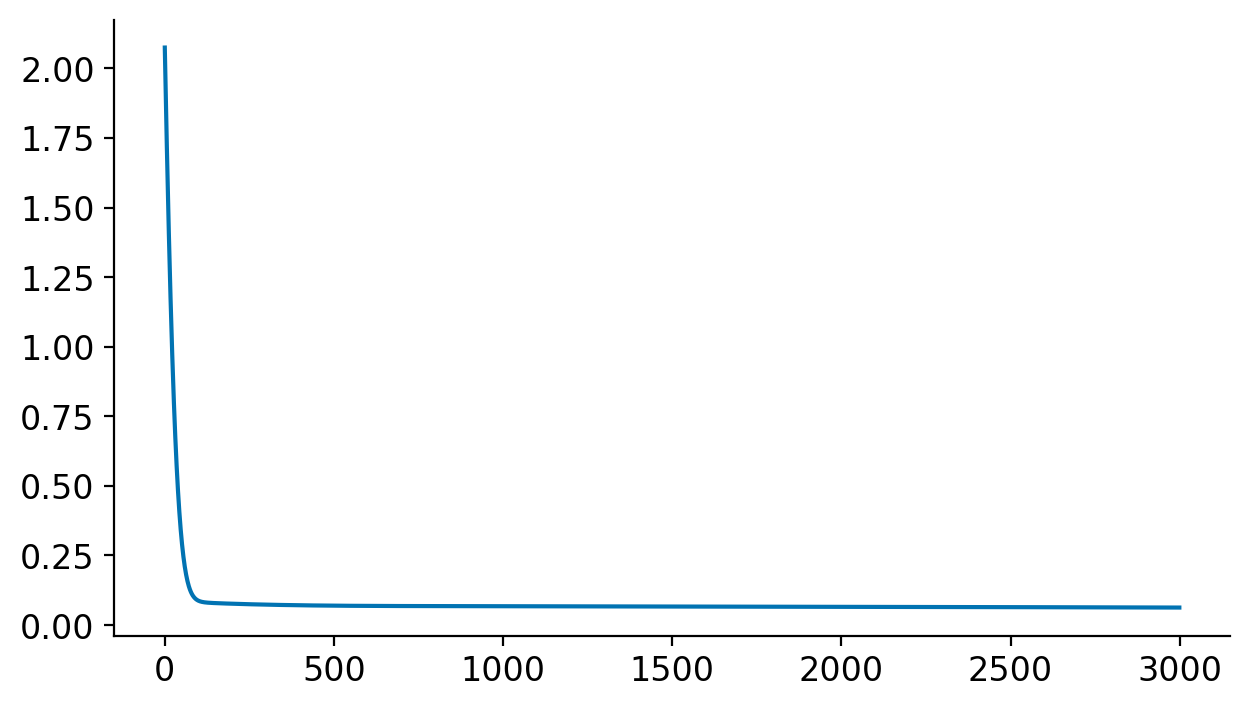

In [667]:
plt.plot(loss)

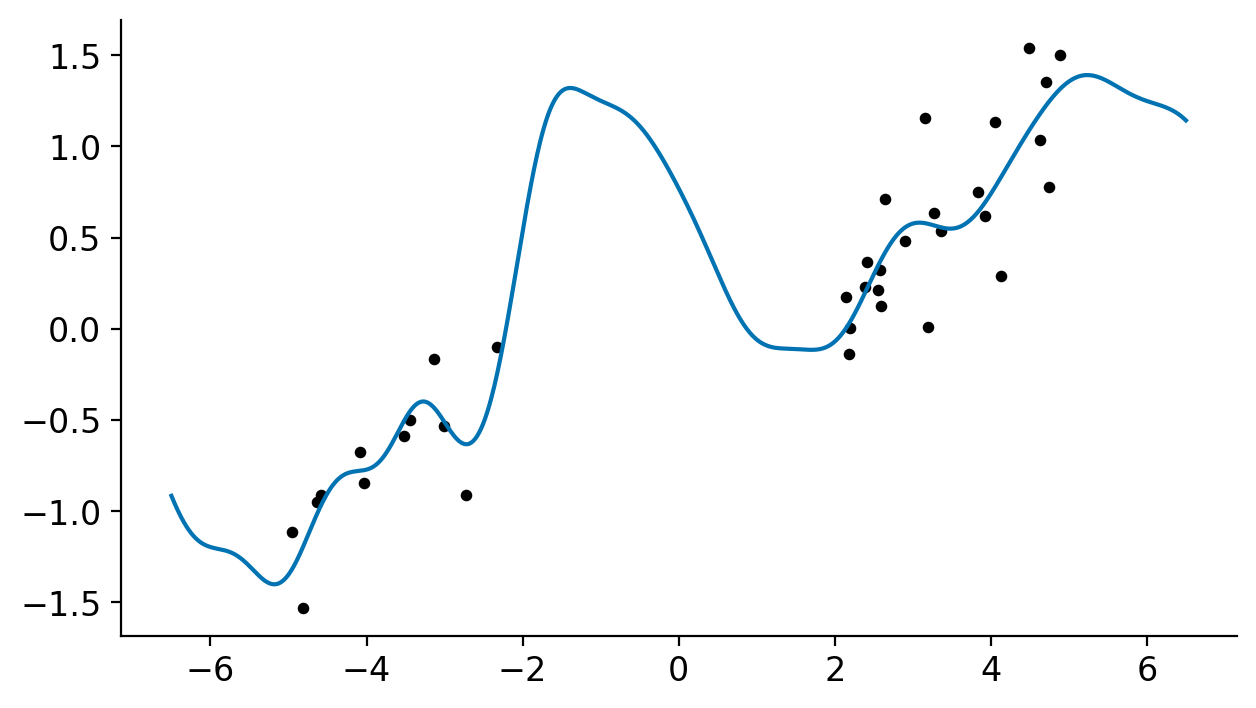

In [669]:
yhat_bnn_eval = model.apply(params, xeval[:, None])
plt.plot(xeval, yhat_bnn_eval)
plt.scatter(x, y, c="black", s=10)

## (plugin) Bayesian Last-layer

In [670]:
class MLPHidden(nn.Module):
    @nn.compact
    def __call__(self, x):
        x = nn.Dense(10)(x)
        x = jnp.sin(x)
        x = nn.Dense(10)(x)
        x = nn.elu(x)
        return x

In [671]:
mhidden = MLPHidden()

In [672]:
params_hidden = deepcopy(params)
del params_hidden["params"]["last-layer"]

In [673]:
def phi(x):
    return mhidden.apply(params_hidden, x)

In [674]:
M = phi(x).shape[1]
IM = jnp.eye(M)
beta = 1 / sigma ** 2 # precision observation

In [679]:
alpha = 0.1

posterior_precision = alpha * IM + beta * phi(x).T @ phi(x)
posterior_mean = beta * jnp.linalg.solve(posterior_precision, phi(x).T @ y)
posterior_mean = posterior_mean.ravel()

In [680]:
n_test_eval = 1000
xeval = jnp.linspace(-6.5, 6.5, n_test_eval)
phi_eval = phi(xeval[:, None])

In [681]:
pred_var_ll = 1 / beta + jnp.einsum("si,ij,sj->s", phi_eval, jnp.linalg.inv(posterior_precision), phi_eval)
pred_std_ll = jnp.sqrt(pred_var)

pred_mean_ll = jnp.einsum("d,td->t", posterior_mean, phi_eval)

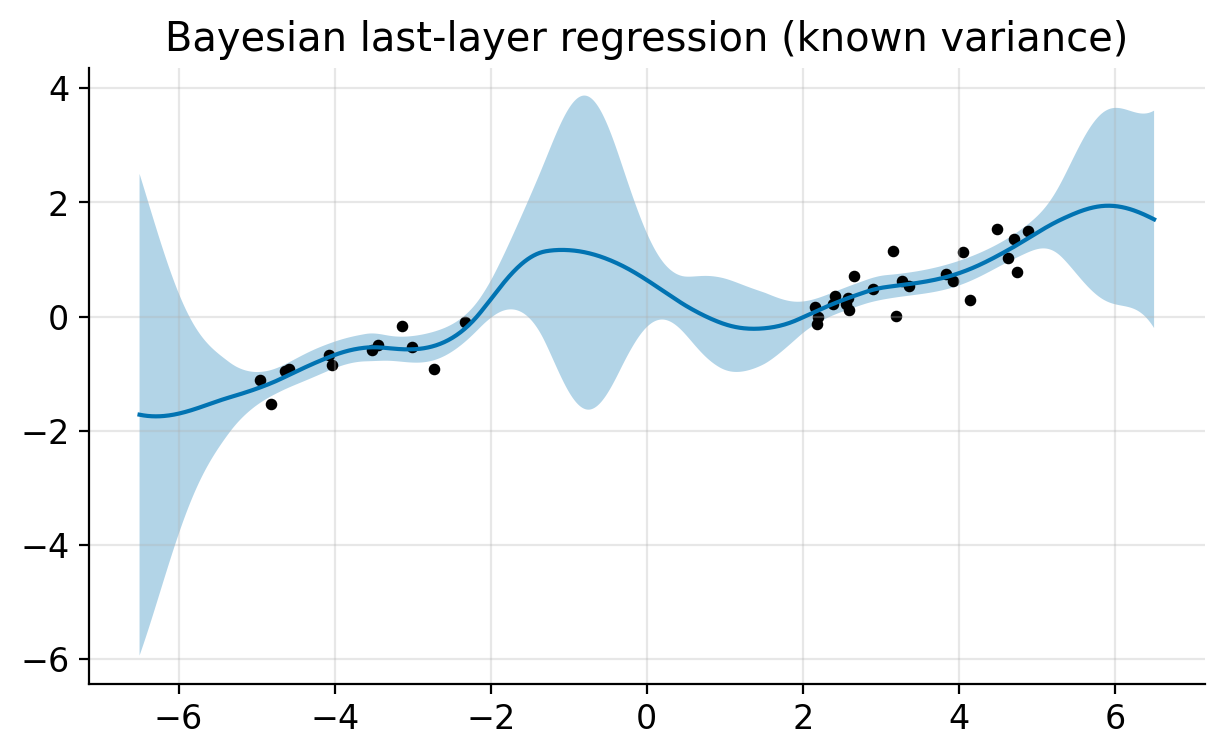

In [682]:
pred_ubound_ll = pred_mean_ll + 2 * pred_var_ll
pred_lbound_ll = pred_mean_ll - 2 * pred_var_ll
plt.fill_between(xeval, pred_lbound_ll, pred_ubound_ll, alpha=0.3)
plt.plot(xeval, pred_mean_ll)
plt.scatter(x, y, c="black", s=10)
plt.title("Bayesian last-layer regression (known variance)")
plt.grid(alpha=0.3)

## References

* Bishop, Christopher M., and Nasser M. Nasrabadi. Pattern recognition and machine learning. Ch 2. Vol. 4. No. 4. New York: springer, 2006.
* Harrison, James, John Willes, and Jasper Snoek. "Variational bayesian last layers." arXiv preprint arXiv:2404.11599 (2024).